In [1]:
%matplotlib inline
import pandas as pd; pd.options.display.float_format = '{:,.3f}'.format
import numpy as np
import seaborn as sns; sns.set_style("dark")
import matplotlib.pyplot as plt; plt.rcParams['figure.figsize'] = (8,6)
from IPython.display import display
from pprint import pprint

from sklearn.model_selection import train_test_split

from ml_tools import make_cross_validation, make_grid_search_clf, plot_roc_curve, make_grid_search_reg

## Data Preparation

In [2]:
def load_data(filename):
    return pd.read_csv("data/" + filename)

target_name = "multiplier"
data = pd.concat([load_data("data2014.csv"), load_data("data2015.csv")])

# X, y = data.drop(target_name, axis=1), data[target_name]
# X_train, X_test, y_train, y_test = train_test_split(X, y)

## Regression
Assumption:

$$(Start Price_i, Duration_i, Estimated Value_i, Period_i) \rightarrow Followers_i \rightarrow Multiplier$$

### Model selection

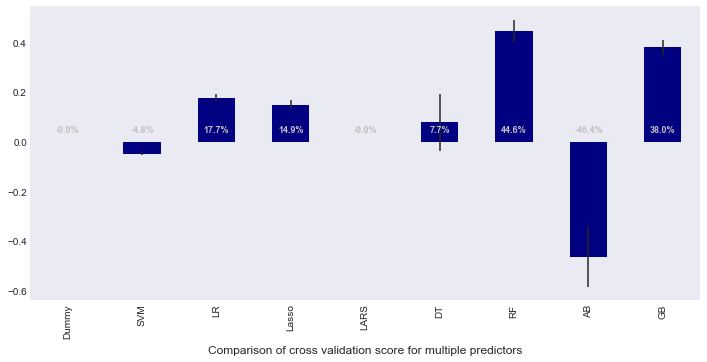

In [3]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso, LassoLars
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score

scoring = "r2"

models = [
    
    ("Dummy", DummyRegressor(strategy="mean")),
    ("SVM", SVR()), 
    ("LR", LinearRegression()),
    ("Lasso", Lasso()),
    ("LARS", LassoLars()),
    ("DT", DecisionTreeRegressor()), 
    ("RF", RandomForestRegressor()),
    ("AB", AdaBoostRegressor()),
    ("GB", GradientBoostingRegressor())
    
]

followers = "Followers"
X, iv, y = data.drop([target_name, followers], axis=1), data[followers], data[target_name]
X_train, X_test, iv_train, iv_test, y_train, y_test = train_test_split(X, iv, y)

cv_results = make_cross_validation(models, scoring, X_train, iv_train)

### Hyperparameters tuning


LinearRegression:

	RMSE: 10.84
	R2 Score (Train set): 17.68%
	R2 Score (Test set): 18.98%

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False) 

####################################################################################################

RandomForestRegressor:

	RMSE: 9.83
	R2 Score (Train set): 34.10%
	R2 Score (Test set): 33.33%

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features=14, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=70, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False) 

####################################################################################################

GradientBoostingRegressor:

	RMSE: 8.54
	R2 Score (Train set): 46.21%
	R2 Score (Test set): 49.65%

GradientBoostingRegressor(alpha=0.9, criterion='fr

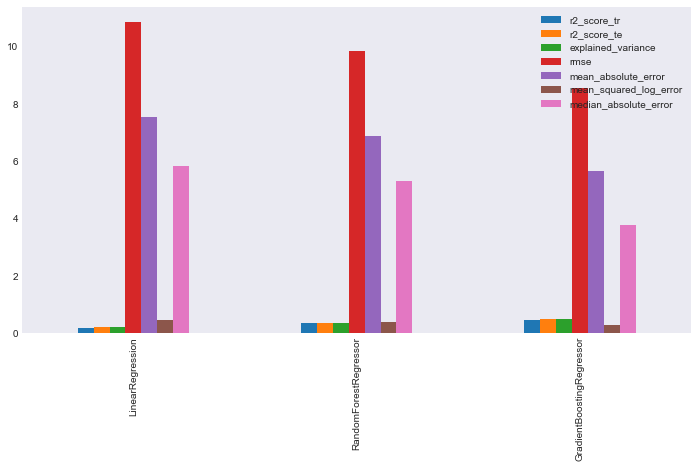

In [4]:
n_features = X_train.shape[1]

regressors = [
    ("LinearRegression", LinearRegression()), 
    ("RandomForestRegressor", RandomForestRegressor(n_estimators=70)),
    ("GradientBoostingRegressor", GradientBoostingRegressor(n_estimators=60, learning_rate=.1, max_features=9))
]

reg_params = {
    "LinearRegression": {
        "normalize": [True, False]
    },
    
    "RandomForestRegressor": {
        "criterion": ["mse", "mae"],
        "max_features": range(5, n_features, (n_features - 5) // 3), 
        "max_depth": range(3, 6, 2),
#         "min_samples_split": range(5, 101, 25),
#         "n_estimators": range(40, 80, 10)
    },
    
    "GradientBoostingRegressor": {
        "min_samples_split" :   range(5, 20, 3),
#         "max_features": range(5, n_features + 1, (n_features - 5) // 4),
        "max_depth": range(3, 16, 4),
#         "learning_rate": np.logspace(-2, 1, 4),
#         "n_estimators": range(40, 80, 10)

    },
}

best_models, results = make_grid_search_reg(regressors, reg_params, X_train, iv_train, X_test, iv_test)

In [5]:
gbr = best_models[-1]
coef = pd.DataFrame(index=X_train.columns)
coef["Feature Importances"] = gbr.feature_importances_
coef.sort_values("Feature Importances", ascending=False)

,Feature Importances
LotNr,0.393
EstValue,0.119
LotsCtgry,0.119
StartPrice,0.105
Duration,0.098
SP.EV,0.075
LotsSale,0.053
Bank,0.010
Dealer,0.008
Forced,0.005


## Classification

### Preprocessing

Prepare data for classification

In [12]:
# bins = np.logspace(-2, 2, 5, base=2)
bins = np.linspace(0, 2, 3)

def cut(X, filter_values, log=False):
    if log: X = np.log2(X)
    X_cut = pd.cut(X, bins=filter_values)
    X_cut = X_cut.map(lambda x: np.argmax(filter_values > x.left) - 1)
    X_cut.loc[X_cut.isnull()] = X[X_cut.isnull()].map(lambda x: len(filter_values) - 2 if x > filter_values[-1] else 0)
    return X_cut

X_train, X_test = pd.concat([X_train, iv_train], axis=1), pd.concat([X_test, iv_test], axis=1)
y_train_bins = cut(y_train, bins, log=False)
y_test_bins = cut(y_test, bins)

/home/quent/.local/bin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


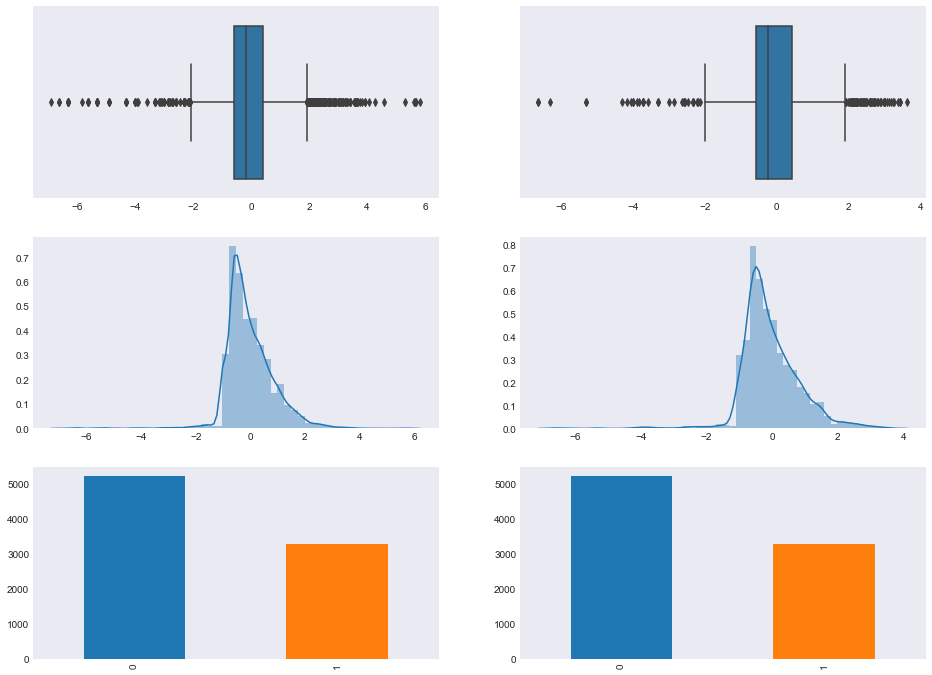

In [13]:
fig, axs = plt.subplots(3, 2, figsize=(16,12))
for i, (series, series_bin) in enumerate(zip([y_train, y_test], [y_train_bins, y_train_bins])):
    sns.boxplot(np.log2(series), ax=axs[0, i % 3])
    sns.distplot(np.log2(series), ax=axs[1, i % 3])
    series_bin.value_counts().sort_index().plot.bar(ax=axs[2, i % 3])
    [ax.set_xlabel("") for ax in axs[:, i % 3]]

### Classification

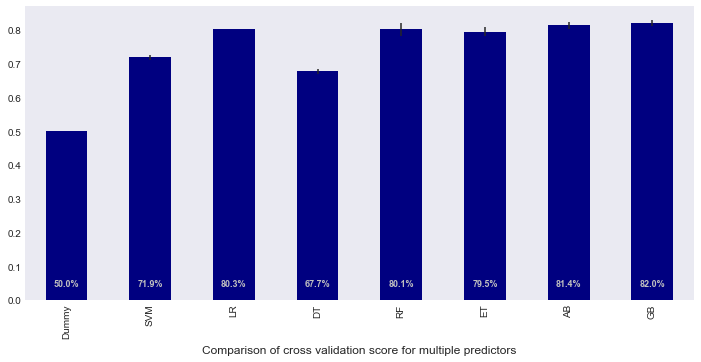

In [14]:
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier
)

scoring = "roc_auc"

models = [
    
    ("Dummy", DummyClassifier(strategy="most_frequent")),
    ("SVM", SVC()), 
    ("LR", LogisticRegression()),
    ("DT", DecisionTreeClassifier()), 
    ("RF", RandomForestClassifier()),
    ("ET", ExtraTreesClassifier()),
    ("AB", AdaBoostClassifier()),
    ("GB", GradientBoostingClassifier())
    
]

cv_results = make_cross_validation(models, scoring, X_train, y_train_bins)


LogisticRegression:

	Accuracy: 74.02%
	AUC Score (Train set): 74.36%
	AUC Score (Test set): 71.98%

             precision    recall  f1-score   support

          0       0.79      0.80      0.79      1771
          1       0.66      0.64      0.65      1058

avg / total       0.74      0.74      0.74      2829

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False) 

####################################################################################################

AdaBoostClassifier:

	Accuracy: 76.67%
	AUC Score (Train set): 75.61%
	AUC Score (Test set): 73.60%

             precision    recall  f1-score   support

          0       0.79      0.86      0.82      1771
          1       0.72      0.61      0.66      1058

avg / total       0.76      0.77      0.76    

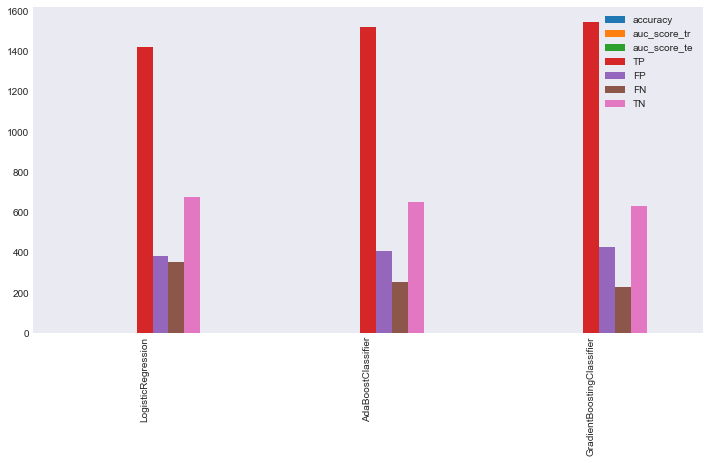

In [16]:
n_features = X_train.shape[1]

base_dt = DecisionTreeClassifier(criterion='entropy', splitter='random')  #max_features="auto", max_depth=None)

classifiers = [
    ("LogisticRegression", LogisticRegression()), 
    ("AdaBoostClassifier", AdaBoostClassifier(base_estimator=base_dt, learning_rate=0.01, n_estimators=60)),
    ("GradientBoostingClassifier", GradientBoostingClassifier(n_estimators=60, learning_rate=0.1))
]

clf_params = {
    "LogisticRegression": {
        "penalty": ["l1", "l2"], 
        "C": np.logspace(-3, 3, 7), 
        "class_weight":["balanced", None]
    },
    
    "AdaBoostClassifier": {
#         "base_estimator__criterion" : ["gini", "entropy"],
#         "base_estimator__splitter" :   ["best", "random"],
        "base_estimator__max_features": range(5, n_features + 1, (n_features - 5) // 4),
        "base_estimator__max_depth": range(3, 16, 4),
#         "learning_rate": np.logspace(-2, 1, 4),
#         "n_estimators": range(40, 80, 10)
    },
    
    "GradientBoostingClassifier": {
        "min_samples_split" :   range(3, 10, 3),
        "max_features": range(5, n_features + 1, (n_features - 5) // 4),
        "max_depth": range(3, 16, 4),
#         "learning_rate": np.logspace(-2, 1, 4),
#         "n_estimators": range(40, 80, 10)

    },
}

best_models, results = make_grid_search_clf(classifiers, clf_params, X_train, y_train_bins, X_test, y_test_bins)

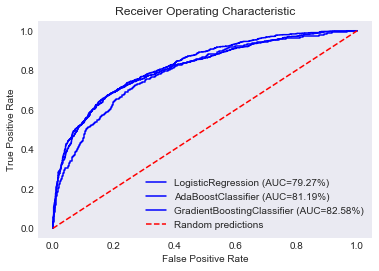

In [17]:
plot_roc_curve(classifiers, best_models, X_test, y_test_bins)

In [18]:
clf = best_models[-1]
coef = pd.DataFrame(index=X_train.columns)
coef["Feature Importances"] = clf.feature_importances_
coef.sort_values("Feature Importances", ascending=False)

,Feature Importances
Followers,0.294
LotNr,0.201
LotsCtgry,0.091
SP.EV,0.087
EstValue,0.086
Duration,0.080
StartPrice,0.072
LotsSale,0.055
Afternoon,0.007
Forced,0.006


In [20]:
import pickle

def load_model(model_name):
    with open(model_name, 'rb') as f:
        model = pickle.load(f)
    return model

gbr = load_model("output/GradientBoostingRegressor.pkl")
adb = load_model("output/AdaBoostClassifier.pkl")